In [57]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
from torch.nn import functional as F

import youtokentome as yttm
import torch.nn as nn

from utils import load, save_texts_to_file, LanguageModelDataset, init_random_seed, get_params_number, train_eval_loop, GreedyGenerator, BeamGenerator

init_random_seed()

In [58]:
print("CUDA доступна:", torch.cuda.is_available())

print("Кол-во доступных GPU:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("Имя GPU:", torch.cuda.get_device_name(0))
    print("Текущий GPU:", torch.cuda.current_device())


CUDA доступна: True
Кол-во доступных GPU: 1
Имя GPU: NVIDIA GeForce RTX 3060 Ti
Текущий GPU: 0


## Создание датасетов для обучения и теста

In [59]:
all_chunks = load('./data/war_and_peace.txt')
len(all_chunks)

7976

In [60]:
print(all_chunks[11])

аписочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez rien de mieux a faire, M. le comte (или mon prince), et si la
perspective de passer la soiree chez 


In [61]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(f'Размеры выборок train/test: \n {len(train_texts)} \n {len(test_texts)}')

Размеры выборок train/test: 
 5583 
 2393


In [62]:
BPE_MODEL_FILENAME = './data/war_and_peace_bpe_train.txt'

TRAIN_TEXT_FILENAME = './data/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXT_FILENAME)
yttm.BPE.train(data=TRAIN_TEXT_FILENAME, vocab_size=2048, model=BPE_MODEL_FILENAME)

Training parameters
  input: ./data/war_and_peace_bpe_train.txt
  model: ./data/war_and_peace_bpe_train.txt
  vocab_size: 1000
  n_threads: 8
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...


learning bpe...
number of unique characters in the training data: 142
number of deleted characters: 0
number of unique characters left: 142
model saved to: ./data/war_and_peace_bpe_train.txt


In [63]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))
print(tokenizer.encode(train_texts[:1]))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

Неизвестных слов: 0


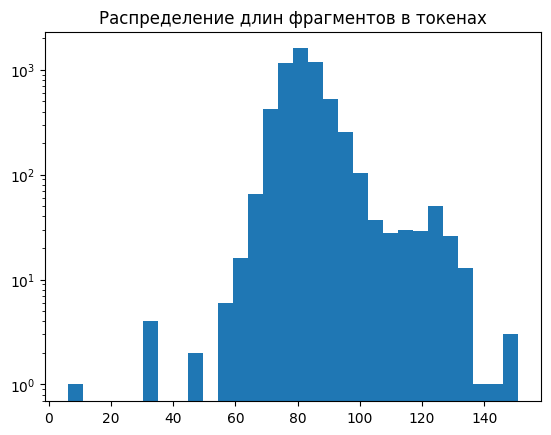

In [64]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

unknown_words = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Неизвестных слов:', unknown_words)

In [65]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(token_ids=train_token_ids, chunk_length=CHUNK_LENGTH, pad_value=0)
test_dataset = LanguageModelDataset(token_ids=test_token_ids, chunk_length=CHUNK_LENGTH, pad_value=0)
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [66]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Классы и функции

In [67]:
def mask_for_attention(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)

    return full_mask

mask_for_attention(4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

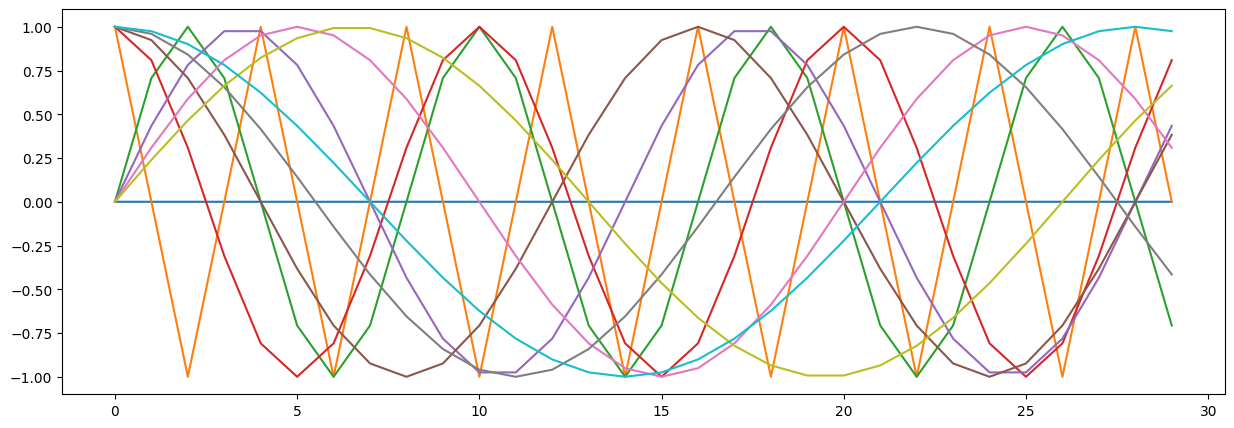

In [68]:
def positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dviders = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dviders[None, :]

    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)

    return result

sample_positional_encoding = positional_encoding(30, 30)
plt.plot(sample_positional_encoding[:, ::3].numpy())
plt.gcf().set_size_inches((15, 5))

## Языковая модель

In [69]:
class LanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size, model, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = torch.nn.Dropout(emb_dropout)
        self.model = model
        self.out = torch.nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        batch_size, max_in_length =  seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        attention_mask = mask_for_attention(max_in_length).to(seed_token_ids.device)

        seed_embs = self.embeddings(seed_token_ids)
        pos_codes = positional_encoding(max_in_length, self.embedding_size).unsqueeze(0).to(seed_embs.device)

        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        target_features = seed_embs
        target_features = self.model(seed_embs, mask=attention_mask, src_key_padding_mask=seed_padding_mask)

        logits = self.out(target_features)
        return logits

## Вспомогательные функции

In [70]:
def lm_cross_entropy(pred, target):
    pred_flat = pred.view(-1, pred.shape[-1])
    target_flat = target.view(-1)

    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

def lr_sheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

In [71]:
class BatchFirstTransformerEncoder(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = torch.nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()

    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()
        result = self.impl(src, *args, **kwargs)
        result = result.transpose(0, 1).contiguous()
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                torch.nn.init.xavier_uniform_(param)
                

In [72]:
torch_model = LanguageModel(vocab_size=tokenizer.vocab_size(), 
                            embedding_size=256, 
                            model=BatchFirstTransformerEncoder(
                                torch.nn.TransformerEncoderLayer(
                                    d_model=256,
                                    nhead=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                num_layers=3),
                            emb_dropout=0.1)

print('Количество параметров:', get_params_number(torch_model))

Количество параметров: 2094312


In [73]:
'''
(best_val_loss, best_torch_model) = train_eval_loop(
    torch_model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=2000,
    batch_size=256,
    device='cuda',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_val=1000,
    lr_scheduler_ctor=lr_sheduler
)
'''

In [74]:
''' torch.save(best_torch_model.state_dict(), './models/war_and_peace_best_encoder.pth') '''

In [75]:
torch_model.load_state_dict(torch.load('./models/war_and_peace_best_encoder.pth'))

<All keys matched successfully>

## Жадная генерация (предсказание наиболее верятного токена на следующем шаге)

In [76]:
greedy_generator = GreedyGenerator(torch_model, tokenizer)

print(greedy_generator('сказала ему княжна, увидев Банопарта'))

сказала ему княжна, увидев Банопарта мою вас. Не было узнать французов, - сказал Денисов. - Целый день... ведьбе броситься, - сказала Анна Павловна, - торжест


## Лучевой поиск - Beem Search

In [ ]:
beam_generator = BeamGenerator(torch_model, tokenizer)

beam_generator_text = beam_generator('сказала княжна, оглядывая Наполе',
                               beamsize=15,
                               return_hypotheses_n=5)

for score, pred_txt in beam_generator_text:
    print('=' * 100)
    print(score)
    print(pred_txt, '\n')

**********
2.613337152421444
сказала княжна, оглядывая Наполеону. - Ah! Andre, - сказала она, - я тебя пр<EOS> 

**********
3.12405381352683
сказала княжна, оглядывая Наполеона, увидав князя Андрея к полкового командира. - Je n'ait pas evants le ropos de Russie, grand 

**********
3.3035831516081946
сказала княжна, оглядывая Наполеона, увидав князя Андрея к полкового сына, выра действия пройской мимо тысяч. - Бонапарте. Есть узнать страх. - Бонапарте, 

**********
3.390350838341794
сказала княжна, оглядывая Наполеона, увидав князя Андрея к полкового сына, выра действия пройской мимо тысяч. - Богданыч позде, - сказал князь Василий Анне Михайловне. - 

**********
3.4219579030542664
сказала княжна, оглядывая Наполеона, увидав князя Андрея к полкового сына, выра действия пройской мимо тысяч. - Богданыч позде, - сказал князь Василий Анне Михайловне. Д 



## Трансформер

In [78]:
def multihead_attention(queries, keys, values,
                        keys_padding_mask, dependency_mask,
                        is_training, weights_dropout):
    
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))

    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))

    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)

    normed_rels_expanded = normed_rels.unsqueeze(-1)
    values_expanded = values.unsqueeze(1)

    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)

    return result, normed_rels

In [79]:
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None

    def forward(self, sequence, padding_mask, dependency_mask):
        batch_size, max_len, model_size = sequence.shape

        queries_flat = self.queries_proj(sequence)
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)

        keys_flat = self.keys_proj(sequence)
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)

        values_flat = self.values_proj(sequence)
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)

        result, att_map = multihead_attention(queries, keys, values,
                                              padding_mask, dependency_mask, self.training, self.dropout)
        
        result_flat = result.view(batch_size, max_len, model_size)

        self.last_attention_map = att_map.detach()

        return result_flat
    

In [80]:
class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(model_size, n_heads, dropout=dropout)
        self.first_dropout = torch.nn.Dropout(dropout)
        self.first_norm = torch.nn.LayerNorm(model_size)

        self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(model_size, dim_feedforward),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(dim_feedforward, model_size),
            torch.nn.Dropout(dropout)
        )

        self.second_norm = torch.nn.LayerNorm(model_size)

    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)

        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)

        return sequence
    

In [81]:
class TransformerEncoder(torch.nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            TransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence
    
    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                torch.nn.init.xavier_uniform_(param)

In [82]:
transformer =  LanguageModel(tokenizer.vocab_size(),
                             256,
                             TransformerEncoder(
                                 n_layers=3,
                                 model_size=256,
                                 n_heads=16,
                                 dim_feedforward=512,
                                 dropout=0.1),
                            emb_dropout=0.1
                             )

print('Количество параметров:', get_params_number(transformer))

Количество параметров: 1896936


In [83]:
(best_val_loss, best_transformer_model) = train_eval_loop(
    transformer,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=2000,
    batch_size=256,
    device='cuda',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_val=1000,
    lr_scheduler_ctor=lr_sheduler
)

Эпоха 0
Эпоха: 22 итераций, 4.31 сек
Среднее значение функции потерь на обучении 6.339890848506581
Среднее значение функции потерь на валидации 6.2485260486602785
Новая лучшая модель!

Эпоха 1
Эпоха: 22 итераций, 4.31 сек
Среднее значение функции потерь на обучении 6.241397727619518
Среднее значение функции потерь на валидации 6.227430963516236
Новая лучшая модель!

Эпоха 2
Эпоха: 22 итераций, 4.30 сек
Среднее значение функции потерь на обучении 6.17548318342729
Среднее значение функции потерь на валидации 6.04660472869873
Новая лучшая модель!

Эпоха 3
Эпоха: 22 итераций, 4.33 сек
Среднее значение функции потерь на обучении 5.899029970169067
Среднее значение функции потерь на валидации 5.698403263092041
Новая лучшая модель!

Эпоха 4
Эпоха: 22 итераций, 4.33 сек
Среднее значение функции потерь на обучении 5.6012045470151035
Среднее значение функции потерь на валидации 5.305302524566651
Новая лучшая модель!

Эпоха 5
Эпоха: 22 итераций, 4.32 сек
Среднее значение функции потерь на обучении

In [84]:
torch.save(best_transformer_model.state_dict(), './models/war_and_peace_best_transformer.pth')

In [85]:
transformer.load_state_dict(torch.load('./models/war_and_peace_best_transformer.pth'))

<All keys matched successfully>

In [86]:
my_greedy_generator = GreedyGenerator(transformer, tokenizer)
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андрея на мягких и поклонился. - Княжна Марья вздрогнула и покраснела пятнами и усилиями'

In [94]:
beam_generator = BeamGenerator(transformer, tokenizer)

beam_generator_text = beam_generator('сказала княжна, оглядывая Андре',
                               beamsize=15,
                               return_hypotheses_n=5)

for score, pred_txt in beam_generator_text:
    print('=' * 100)
    print(score)
    print(pred_txt, '\n')

2.2500703678033274
сказала княжна, оглядывая Андре<EOS> 

2.817464610923769
сказала княжна, оглядывая Андрея на м<EOS> 

3.6640289692739643
сказала княжна, оглядывая Андрея вниз. Княжна Марья молча посмотрела на него и на батальон прекрасного головаты. Перед самым обедом граф Илья Андреич сидел перед ни 

3.684099953460398
сказала княжна, оглядывая Андрея вниз. Княгиня говорила без умолку. - Non, ma chere, - отвечал князь Василий, - и княжна Марья. - Prince Hyppol 

3.8130553678299446
сказала княжна, оглядывая Андрея вниз. Княгиня говорила без умолку. - Non, ma chere, - отвечал князь Василий, - и княжна Марья. - Prince Hypoli 



In [91]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MultiHeadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

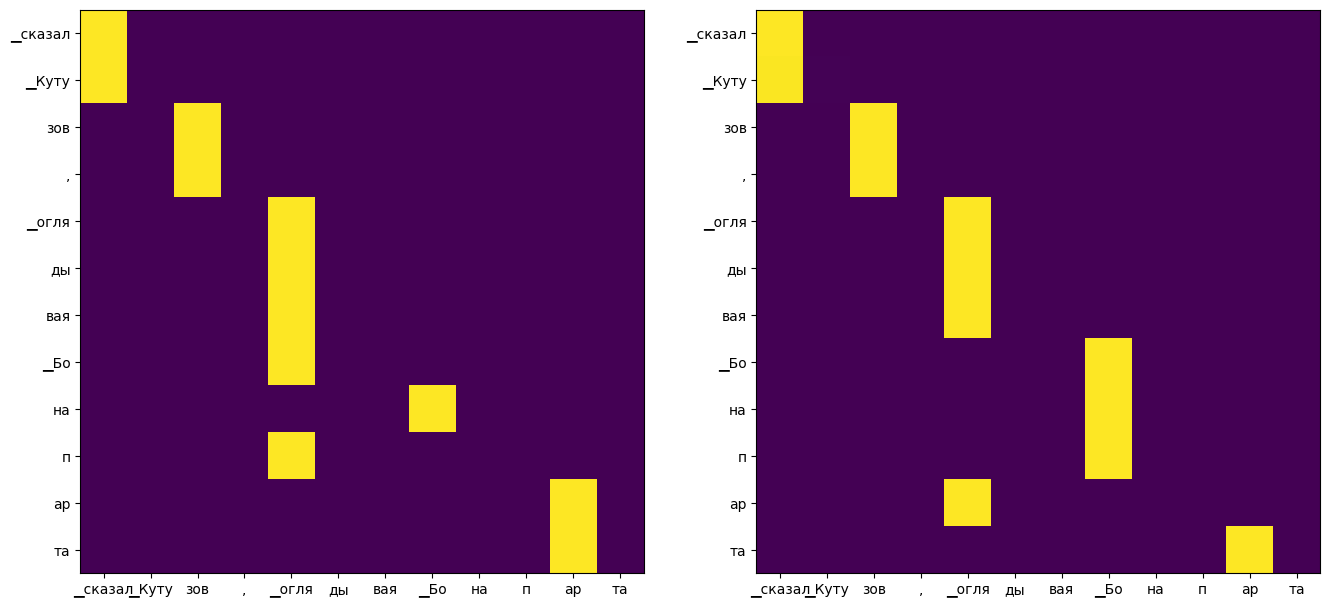

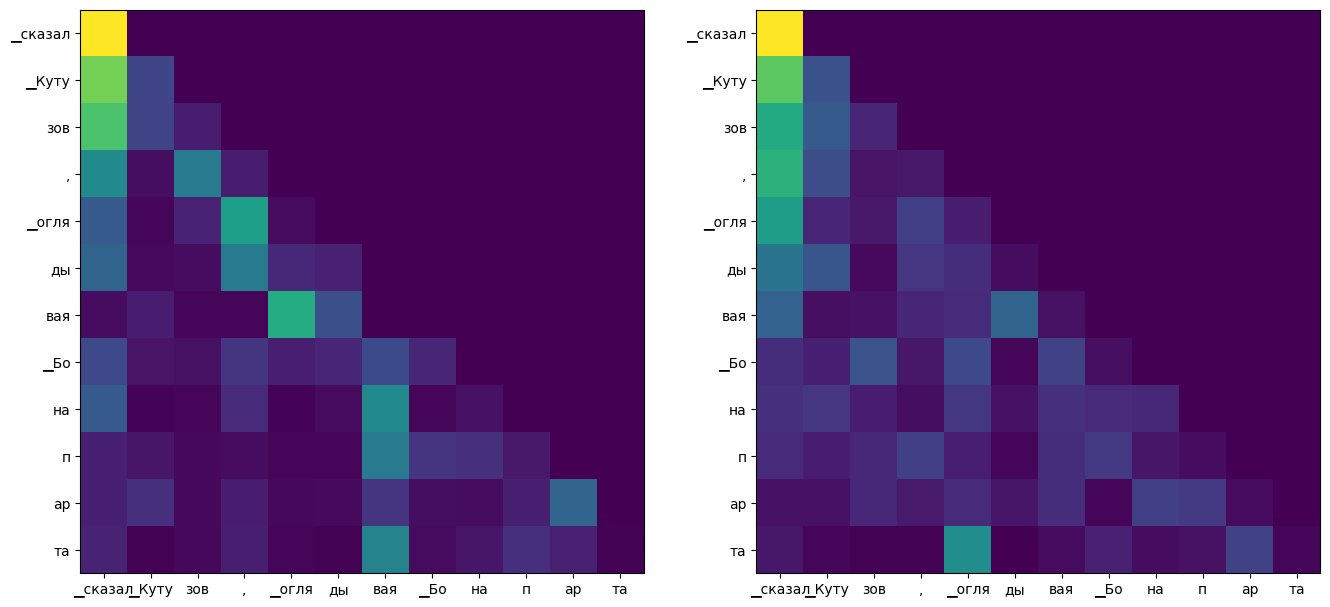

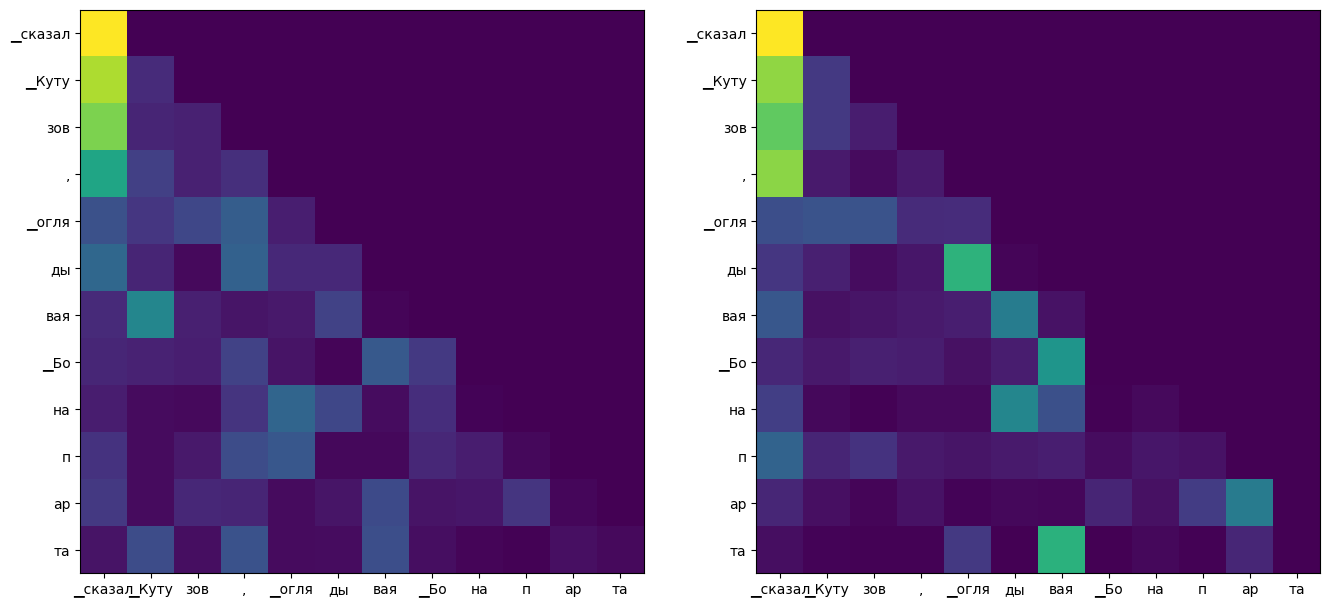

In [92]:
plot_attention_maps(transformer, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)